In [ ]:
#@title Get model coordinates
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/coron/input_files/distan_lat42.58lon-8.804p3R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [ ]:
#@title Get station sample mean wind speed hour before (Beaufort)
from pandas.core.arrays import categorical
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/coron/input_files/coron.csv", usecols = ["time","spd_coron"],parse_dates=["time"]).set_index("time")
#print("raw data\n",station.head(24))

#show duplicated
df_duplicate = station[station.index.duplicated()]
#print("duplicated")
#print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]
station = station.resample("H",label="right",closed="right").mean()

#label
#dir udr to interval
labels = ["F0","F1","F2","F3","F4","F5","F6","F7","F8","F9","F10","F11","F12"]
interval = pd.IntervalIndex.from_tuples([(-1, 0.5), (.5, 1.5), (1.5, 3.3),(3.3,5.5),
                                     (5.5,8),(8,10.7),(10.7,13.8),(13.8,17.1),
                                     (17.1,20.7),(20.7,24.4),(24.4,28.4),(28.4,32.6),(32.6,60)])

station["spd_o_l_all"] = pd.cut(station["spd_coron"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
print("Climatology all")
display((station["spd_o_l_all"].value_counts(normalize=True)*100).map('{:.3f}%'.format))

#new labels
labels = ["F0","F1","F2","F3","F4","F5","F6+"]
interval = pd.IntervalIndex.from_tuples([(-1, 0.5), (.5, 1.5), (1.5, 3.3),(3.3,5.5),
                                     (5.5,8),(8,10.7),(10.7,60)])
station["spd_o_l"] = pd.cut(station["spd_coron"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
print("Climatology selected")
display((station["spd_o_l"].value_counts(normalize=True)*100).map('{:.3f}%'.format))
station = station.drop(["spd_coron","spd_o_l_all"],axis=1)


Climatology all


F3     22.098%
F2     21.921%
F4     20.393%
F1     14.618%
F5     13.198%
F0      4.418%
F6      3.199%
F7      0.155%
F8      0.000%
F9      0.000%
F10     0.000%
F11     0.000%
F12     0.000%
Name: spd_o_l_all, dtype: object

Climatology selected


F3     22.098%
F2     21.921%
F4     20.393%
F1     14.618%
F5     13.198%
F0      4.418%
F6+     3.354%
Name: spd_o_l, dtype: object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17281 entries, 2022-01-03 00:00:00 to 2023-12-31 00:00:00
Data columns (total 76 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   spd_o_l      17281 non-null  category
 1   dir0         17281 non-null  float64 
 2   snow_prec0   17281 non-null  float64 
 3   snowlevel0   17281 non-null  float64 
 4   mod0         17281 non-null  float64 
 5   wind_gust0   17281 non-null  float64 
 6   mslp0        17281 non-null  float64 
 7   temp0        17281 non-null  float64 
 8   rh0          17281 non-null  float64 
 9   visibility0  17281 non-null  float64 
 10  lhflx0       17281 non-null  float64 
 11  lwflx0       17281 non-null  float64 
 12  conv_prec0   17281 non-null  float64 
 13  prec0        17281 non-null  float64 
 14  swflx0       17281 non-null  float64 
 15  shflx0       17281 non-null  float64 
 16  cape0        17281 non-null  float64 
 17  cin0         17281 non-null  float

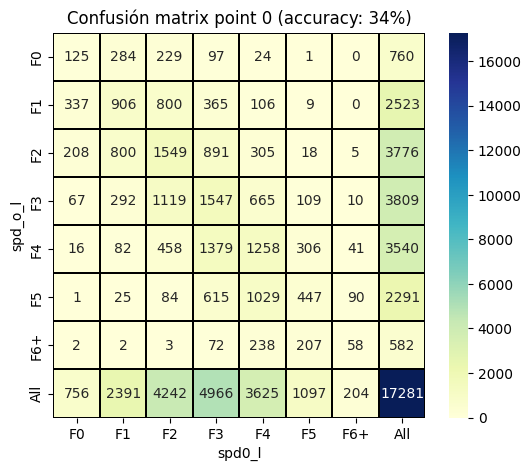

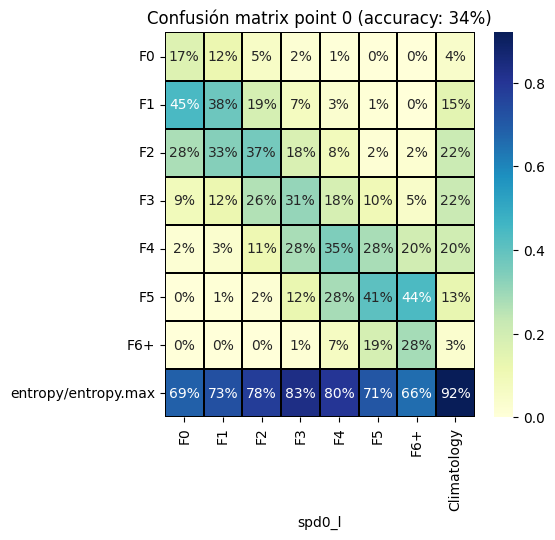

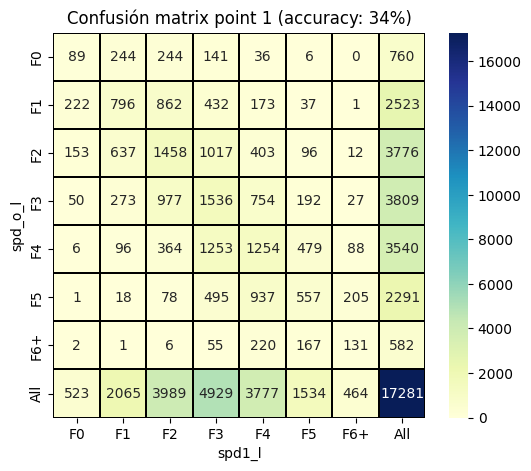

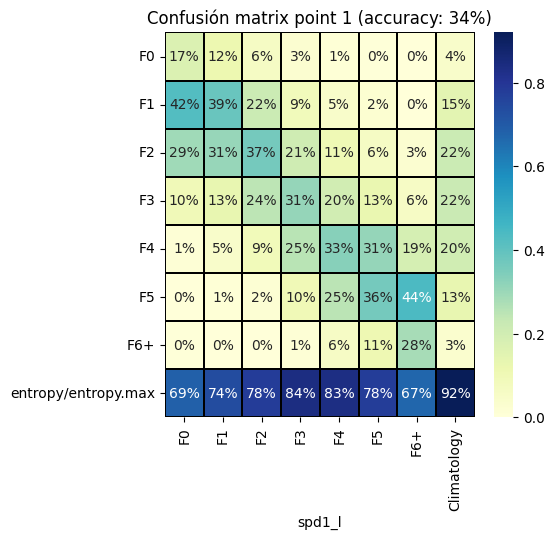

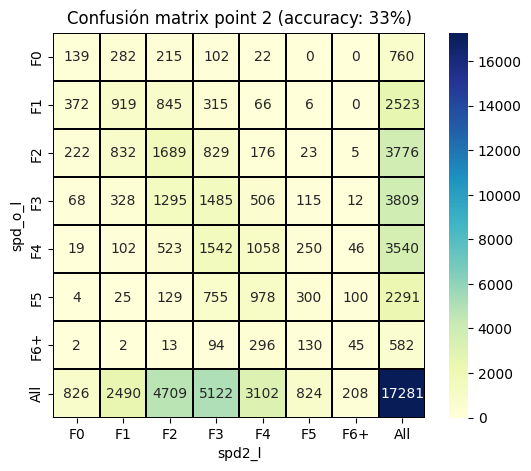

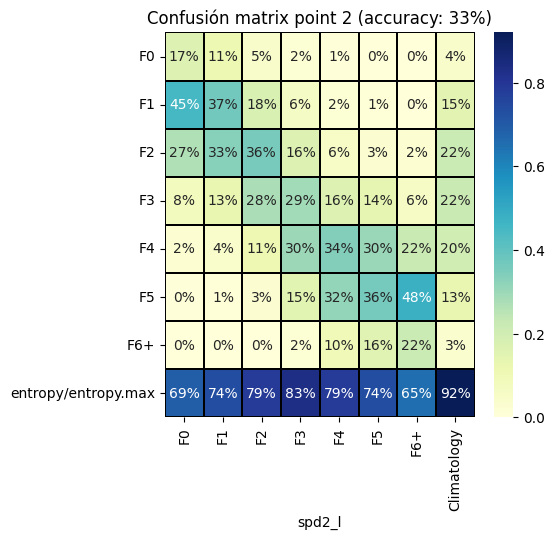

In [ ]:
#@title Get meteorologic model d2. Compare meteorological model variables mod1, mod2 and mod3 versus spd_o_l from the station

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import entropy

# get model
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/coron/input_files/lat42.58lon-8.804p3R1KmD2.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
met_model.drop_duplicates()
df_all = pd.concat([station,met_model],axis=1).dropna()
df_all.info()


#label dir 0,1 and 2
df_all["spd0_l"] = pd.cut(df_all["mod0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["spd1_l"] = pd.cut(df_all["mod1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["spd2_l"] = pd.cut(df_all["mod2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

acc0 = accuracy_score(df_all.spd_o_l, df_all.spd0_l)
acc1 = accuracy_score(df_all.spd_o_l, df_all.spd1_l)
acc2 = accuracy_score(df_all.spd_o_l, df_all.spd2_l)

#point 0
plt.figure(figsize=(6, 5))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
global_sc = pd.crosstab(df_all.spd_o_l, df_all.spd0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(5,5))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
column_sc = pd.crosstab(df_all.spd_o_l, df_all.spd0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})

sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point 1
plt.figure(figsize=(6, 5))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
global_sc = pd.crosstab(df_all.spd_o_l, df_all.spd1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(5, 5))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
column_sc = pd.crosstab(df_all.spd_o_l, df_all.spd1_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point 3
plt.figure(figsize=(6, 5))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
global_sc = pd.crosstab(df_all.spd_o_l, df_all.spd2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(5, 5))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
column_sc = pd.crosstab(df_all.spd_o_l, df_all.spd2_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


#delete met model label columns
df_all = df_all.drop(["spd0_l","spd1_l","spd2_l"],axis=1)

#best accuracy point 3
acc_best = acc0

machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
Accuracy Machine learning models


,acc_t
count,10.000000
mean,0.481000
std,0.008756
min,0.470000
25%,0.472500
50%,0.480000
75%,0.490000
max,0.490000


Accuracy machine learning models:
 [0.49, 0.47, 0.47, 0.48, 0.49, 0.48, 0.48, 0.49, 0.47, 0.49]
*************************************

Score position


1    844
2    482
3    240
4    103
5     40
6     18
7      2
Name: position, dtype: int64

************


1    49%
2    28%
3    14%
4     6%
5     2%
6     1%
7     0%
Name: position, dtype: object

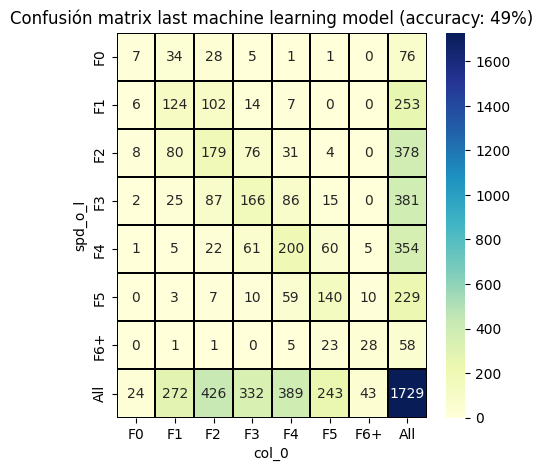

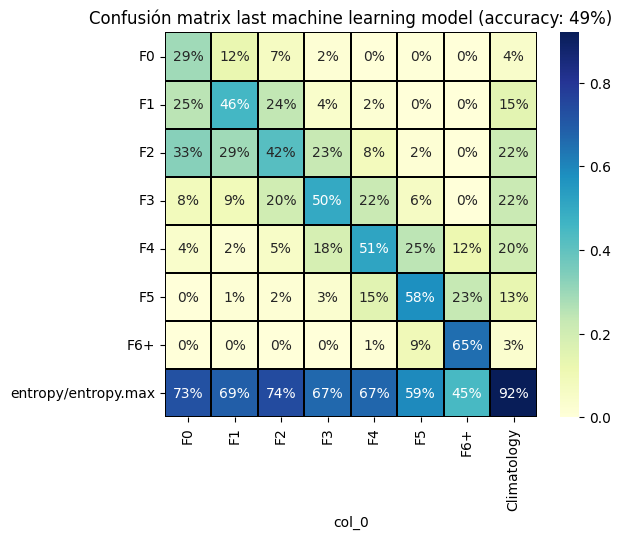

In [ ]:
#@title Add time variables. Train LGBMClassifier. Show machine learning results last split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.spd_o_l
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,stratify=Y )
  ml_model = LGBMClassifier(n_estimators=200,verbose=0,).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))
  print("machine learning number:",t)


print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

print("Accuracy machine learning models:\n",acc_t)
print("*************************************\n")
plt.figure(figsize=(5, 5))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
global_sc = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(6, 5))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
column_sc = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})

sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#probabilistic check
df = pd.DataFrame(ml_model.predict_proba(X_test),columns = sorted(labels))
df['Ordered_Columns'] = df.apply(lambda row: list(row.sort_values(ascending=False).index), axis=1)
df["y_pred"]= y_pred.astype(str)
df["y_test"] =y_test.values.astype(str)
df["position"] = [df.Ordered_Columns[t].index(df.y_test[t])+1 for t in df.index]
print("Score position")
display(df["position"].value_counts())
print("************")
display(df["position"].value_counts(normalize=True).map(lambda x: '{:.0%}'.format(x)))


In [ ]:
#@title Save algorithm
import pickle
from sklearn.pipeline import Pipeline

score ={"acc_met":round(acc_best,2),"acc_ml":acc_t[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/coron/algorithms/spd_coron_d2.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200, verbose=0))])


machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
Accuracy Machine learning models


,acc_extra
count,10.000000
mean,0.491000
std,0.013703
min,0.460000
25%,0.490000
50%,0.490000
75%,0.500000
max,0.510000


Accuracy machine learning models:
 [0.5, 0.46, 0.5, 0.49, 0.49, 0.51, 0.49, 0.5, 0.48, 0.49]
*************************************

Score position


1    840
2    494
3    224
4    106
5     38
6     25
7      2
Name: position, dtype: int64

************


1    49%
2    29%
3    13%
4     6%
5     2%
6     1%
7     0%
Name: position, dtype: object

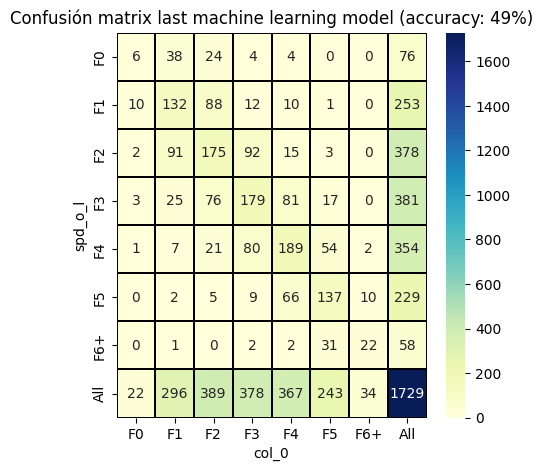

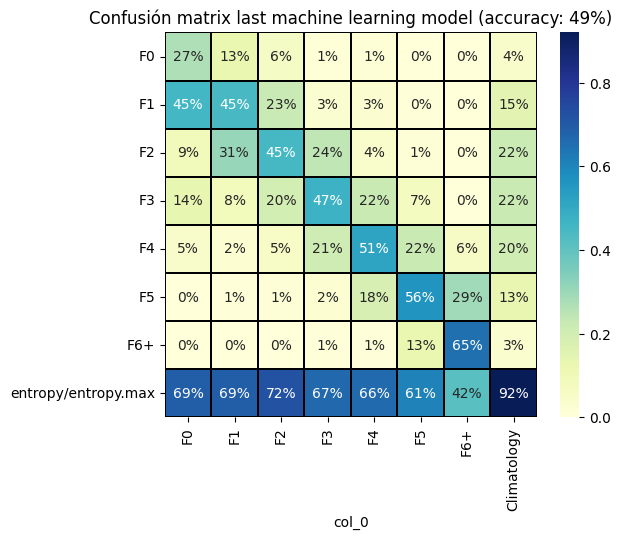

In [ ]:
#@title Train ExtratreesClassifier. Show machine learning results last split

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.spd_o_l
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_extra = []
for t in range (0,10):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,stratify=Y )
  #ml_model = LGBMClassifier(n_estimators=200,verbose=0,force_col_wise=True).fit(X_train,y_train)
  ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_extra.append(round(accuracy_score(y_test,y_pred),2))
  print("machine learning number:",t)


print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_extra":acc_extra,});
display(df_r.describe())

print("Accuracy machine learning models:\n",acc_extra)
print("*************************************\n")
plt.figure(figsize=(5, 5))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_extra[-1]))
global_sc = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(6, 5))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_extra[-1]))
column_sc = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})

sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#probabilistic check
df = pd.DataFrame(ml_model.predict_proba(X_test),columns = sorted(labels))
df['Ordered_Columns'] = df.apply(lambda row: list(row.sort_values(ascending=False).index), axis=1)
df["y_pred"]= y_pred.astype(str)
df["y_test"] =y_test.values.astype(str)
df["position"] = [df.Ordered_Columns[t].index(df.y_test[t])+1 for t in df.index]
print("Score position")
display(df["position"].value_counts())
print("************")
display(df["position"].value_counts(normalize=True).map(lambda x: '{:.0%}'.format(x)))


In [ ]:
# @title T test two related samples. This is a test for the null hypothesis that two related samples have identical accuracy. Alternative hypothesis the accuracy from the sample with extratrees is more than the accuracy with lgbm. Significance level (alpha) = 0.05
from scipy import stats

alpha = 0.05
sta, p_value = stats.ttest_rel( acc_extra, acc_t , alternative="greater")

print("\nAccuracy Lgbm:",acc_t )
print("\nAccuracy extratrees:", acc_extra)
print("\nalpha: ",alpha)
print("\np_value point: ",p_value)

if p_value < alpha:
    print("\nwe are rejecting null hypothesis  H0: accuracy lgbm less than  accuracy extratrees")

else:
    print("\nwe are accepting null hypothesis: H0: accuracy lgbm = accuracy extratrees")





Accuracy Lgbm: [0.49, 0.47, 0.47, 0.48, 0.49, 0.48, 0.48, 0.49, 0.47, 0.49]

Accuracy extratrees: [0.5, 0.46, 0.5, 0.49, 0.49, 0.51, 0.49, 0.5, 0.48, 0.49]

alpha:  0.05

p_value point:  0.015973866351748186

we are rejecting null hypothesis  H0: accuracy lgbm less than  accuracy extratrees
